# GENERIC NAME LTD MOVIES ANALYSIS

> **Author**: Group 5


## 1. INTRODUCTION

### Business Problem

<img src="Images/Movie_Studio.jpg" width="100%" align="center" />

Generic Name LTD is looking to expand into the movie business. As the data analyst division, we have been tasked with exploring what types of films are currently doing well at the box office and translate those findings into actionable insights.

### Business Recommendations

We are looking to find:
* the best genres to make movies of
* the best runtime on average
* the best collaborators (writer, director, actor, etc)
* collaborators and genres that do well internationally
* best release times


## 2. DATA CLEANING

We will be using data from the well known movie databases **Box Office Mojo**, **IMDB** and **Rotten Tomatoes** to come to our conclusions as well as the Python libraries **pandas** and **sqlite3** to help us access and analyze the data.

In this section, we will be cleaning the data by doing such things as:
* dropping duplicates if there are any
* filling null values with appropriate placeholders
* giving columns their appropriate data types, and
* creating new columns to hold extra information (feature engineering)

In [1]:
import pandas as pd
import sqlite3
import numpy as np

conn = sqlite3.connect('./Data/im.db')

### a) Box Office Mojo

In [2]:
BOM_Data = pd.read_csv('./Data/bom.movie_gross.csv')
BOM_Data.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


The Box Office Mojo Data is made up of 5 columns:
* title
* studio
* domestic_gross
* foreign_gross
* year

These store information about various movie titles such as the studios that made them, the amount of money they made as well as the years they were released.

In [3]:
BOM_Data[BOM_Data.duplicated()]

,title,studio,domestic_gross,foreign_gross,year


In [4]:
BOM_Data.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

The BOM data contains no duplicates. It has null values in the studio, domestic gross and foreign gross columns.

We will replace the null values in these columns as well as change the datatype of the `foreign_gross` column from text to number.

We will also add a new column called `total_earnings` that is the sum of the foreign and domestic gross.

In [5]:
# Replace nulls in studio and domestic gross
BOM_Data['studio'] = BOM_Data['studio'].fillna('')
BOM_Data['domestic_gross'] = BOM_Data['domestic_gross'].fillna(0)

# Convert the foreign_gross column to a numeric column after replacing all commas with ''
BOM_Data['foreign_gross'] = pd.to_numeric(
    BOM_Data['foreign_gross'].astype(str).str.replace(',', ''),
    errors='coerce'
)

# Replace NaN in foreign_gross to 0
BOM_Data['foreign_gross'] = BOM_Data['foreign_gross'].fillna(0)

# Add a new column total_earnings
BOM_Data['total_earnings'] = BOM_Data['domestic_gross'] + BOM_Data['foreign_gross']

BOM_Data.head()

,title,studio,domestic_gross,foreign_gross,year,total_earnings
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08


### b) IMDB

In [6]:
pd.read_sql('''
    SELECT name
    FROM sqlite_master
    WHERE type = 'table';
''', conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


The IMDB data has 8 tables:
* movie_basics
* directors
* known_for
* movie_akas
* movie_ratings
* persons
* principals
* writers

The tables have the following relationship:

<img src="Images/IMDB_ERD.png" width="50%" align="center" />

Let's examine each table.

In [7]:
IMDB_Movie_Basics_Data = pd.read_sql('''
    SELECT *
    FROM movie_basics;
''', conn)
IMDB_Directors_Data = pd.read_sql('''
    SELECT *
    FROM directors;
''', conn)
IMDB_known_for_Data = pd.read_sql('''
    SELECT *
    FROM known_for;
''', conn)
IMDB_Movie_AKAs_Data = pd.read_sql('''
    SELECT *
    FROM movie_akas;
''', conn)
IMDB_Movie_Ratings_Data = pd.read_sql('''
    SELECT *
    FROM movie_ratings;
''', conn)
IMDB_Persons_Data = pd.read_sql('''
    SELECT *
    FROM persons;
''', conn)
IMDB_Principals_Data = pd.read_sql('''
    SELECT *
    FROM principals;
''', conn)
IMDB_Writers_Data = pd.read_sql('''
    SELECT *
    FROM writers;
''', conn)

#### i) movie_basics

In [8]:
IMDB_Movie_Basics_Data.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [9]:
IMDB_Movie_Basics_Data[IMDB_Movie_Basics_Data.duplicated()]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres


In [10]:
IMDB_Movie_Basics_Data.isna().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

`movie_basics` has no duplicates but some null values. Let's replace the null values.

In [11]:
IMDB_Movie_Basics_Data['original_title'] = IMDB_Movie_Basics_Data['original_title'].fillna('')
# Fill empty runtime with the average
IMDB_Movie_Basics_Data['runtime_minutes'] = IMDB_Movie_Basics_Data['runtime_minutes'].fillna(IMDB_Movie_Basics_Data['runtime_minutes'].mean())
IMDB_Movie_Basics_Data['genres'] = IMDB_Movie_Basics_Data['genres'].fillna('')

IMDB_Movie_Basics_Data.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

#### ii) directors

In [12]:
IMDB_Directors_Data[IMDB_Directors_Data.duplicated()]

,movie_id,person_id
3,tt0835418,nm0151540
9,tt0996958,nm2286991
11,tt0999913,nm0527109
12,tt0999913,nm0527109
13,tt0999913,nm0527109
...,...,...
291155,tt8976710,nm1639277
291160,tt8992390,nm0504267
291161,tt8992390,nm0504267
291162,tt8992390,nm0504267


In [13]:
IMDB_Directors_Data = IMDB_Directors_Data.drop_duplicates()
IMDB_Directors_Data[IMDB_Directors_Data.duplicated()]

,movie_id,person_id


In [14]:
IMDB_Directors_Data.isna().sum()

movie_id     0
person_id    0
dtype: int64

#### iii) known_for

In [15]:
IMDB_known_for_Data[IMDB_known_for_Data.duplicated()]

,person_id,movie_id


In [16]:
IMDB_known_for_Data.isna().sum()

person_id    0
movie_id     0
dtype: int64

#### iv) movie_aka

In [17]:
IMDB_Movie_AKAs_Data[IMDB_Movie_AKAs_Data.duplicated()]

,movie_id,ordering,title,region,language,types,attributes,is_original_title


In [18]:
IMDB_Movie_AKAs_Data.isna().sum()

movie_id                  0
ordering                  0
title                     0
region                53293
language             289988
types                163256
attributes           316778
is_original_title        25
dtype: int64

In [19]:
IMDB_Movie_AKAs_Data.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [20]:
IMDB_Movie_AKAs_Data['region'] = IMDB_Movie_AKAs_Data['region'].fillna('')
IMDB_Movie_AKAs_Data['language'] = IMDB_Movie_AKAs_Data['language'].fillna('')
IMDB_Movie_AKAs_Data['types'] = IMDB_Movie_AKAs_Data['types'].fillna('')
IMDB_Movie_AKAs_Data['attributes'] = IMDB_Movie_AKAs_Data['attributes'].fillna('')
IMDB_Movie_AKAs_Data['is_original_title'] = IMDB_Movie_AKAs_Data['attributes'].fillna(0)

IMDB_Movie_AKAs_Data.isna().sum()

movie_id             0
ordering             0
title                0
region               0
language             0
types                0
attributes           0
is_original_title    0
dtype: int64

#### v) movie_ratings

In [21]:
IMDB_Movie_Ratings_Data[IMDB_Movie_Ratings_Data.duplicated()]

,movie_id,averagerating,numvotes


In [22]:
IMDB_Movie_Ratings_Data.isna().sum()

movie_id         0
averagerating    0
numvotes         0
dtype: int64

#### vi) persons

In [23]:
IMDB_Persons_Data[IMDB_Persons_Data.duplicated()]

,person_id,primary_name,birth_year,death_year,primary_profession


In [24]:
IMDB_Persons_Data.isna().sum()

person_id                  0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
dtype: int64

In [25]:
IMDB_Persons_Data.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [26]:
IMDB_Persons_Data['birth_year'] = IMDB_Persons_Data['birth_year'].fillna(np.ceil(IMDB_Persons_Data['birth_year'].mean()))
IMDB_Persons_Data['death_year'] = IMDB_Persons_Data['death_year'].fillna(np.ceil(IMDB_Persons_Data['death_year'].mean()))
IMDB_Persons_Data['primary_profession'] = IMDB_Persons_Data['primary_profession'].fillna('')

IMDB_Persons_Data.isna().sum()

person_id             0
primary_name          0
birth_year            0
death_year            0
primary_profession    0
dtype: int64

#### vii) principals

In [27]:
IMDB_Principals_Data[IMDB_Principals_Data.duplicated()]

,movie_id,ordering,person_id,category,job,characters


In [28]:
IMDB_Principals_Data.isna().sum()

movie_id           0
ordering           0
person_id          0
category           0
job           850502
characters    634826
dtype: int64

In [29]:
IMDB_Principals_Data.head()

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


In [30]:
IMDB_Principals_Data['job'] = IMDB_Principals_Data['job'].fillna('')
IMDB_Principals_Data['characters'] = IMDB_Principals_Data['characters'].fillna('')

IMDB_Principals_Data.isna().sum()

movie_id      0
ordering      0
person_id     0
category      0
job           0
characters    0
dtype: int64

#### viii) writers

In [31]:
IMDB_Writers_Data[IMDB_Writers_Data.duplicated()]

,movie_id,person_id
7,tt0878654,nm0284943
8,tt0878654,nm0284943
47,tt10140002,nm0104200
77,tt1323592,nm2598931
79,tt1323592,nm0132843
...,...,...
255818,tt8856070,nm2532982
255820,tt8856070,nm2537532
255822,tt8865986,nm6676529
255824,tt8865986,nm10058226


In [32]:
IMDB_Writers_Data = IMDB_Writers_Data.drop_duplicates()

IMDB_Writers_Data[IMDB_Writers_Data.duplicated()]

,movie_id,person_id


In [33]:
IMDB_Writers_Data.isna().sum()

movie_id     0
person_id    0
dtype: int64

### c) Rotten Tomatoes

The Rotten Tomatoes data is divided into two:
* `rt.movie_info.tsv`: stores data on movie info such as director, box office and runtime
* `rt.reviews.tsv`: stors data on movie reviews done by critics

In [34]:
RT_Movie_Data = pd.read_csv('./Data/rt.movie_info.tsv', sep='\t')
RT_Movie_Data.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [35]:
RT_Review_Data = pd.read_csv('./Data/rt.reviews.tsv', sep='\t', encoding='latin1')
RT_Review_Data.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [36]:
RT_Movie_Data[RT_Movie_Data.duplicated()]

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio


In [37]:
RT_Review_Data[RT_Review_Data.duplicated()]

,id,review,rating,fresh,critic,top_critic,publisher,date
8129,304,"Friends With Kids is a smart, witty and potty-...",NaN,fresh,NaN,0,Liverpool Echo,"June 29, 2012"
14575,581,NaN,4.5/5,fresh,NaN,0,Film Threat,"December 6, 2005"
26226,1055,NaN,4/5,fresh,NaN,0,Film Threat,"December 6, 2005"
35162,1368,NaN,2/5,rotten,NaN,0,Film Threat,"December 6, 2005"
35166,1368,NaN,2/5,rotten,NaN,0,Film Threat,"December 8, 2002"
40567,1535,NaN,2/5,rotten,NaN,0,Film Threat,"December 6, 2005"
42381,1598,"This tired, neutered action thriller won't cau...",2/5,rotten,NaN,0,Empire Magazine,"November 14, 2008"
49487,1843,NaN,0.5/5,rotten,NaN,0,Film Threat,"December 6, 2005"
49492,1843,NaN,0.5/5,rotten,NaN,0,Film Threat,"December 8, 2002"


`RT_Movie_Data` contains no duplicates. However, `RT_Review_Data` contains 9 duplicates. We will drop them.

In [38]:
RT_Review_Data = RT_Review_Data.drop_duplicates()
RT_Review_Data[RT_Review_Data.duplicated()]

,id,review,rating,fresh,critic,top_critic,publisher,date


In [39]:
RT_Movie_Data.isna().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

In [40]:
RT_Review_Data.isna().sum()

id                0
review         5556
rating        13516
fresh             0
critic         2713
top_critic        0
publisher       309
date              0
dtype: int64

Both `RT_Review_Data` and `RT_Movie_Data` contain null values. We will replace them and convert columns to their appropriate data types.

> Note that for the `theater_date` and `dvd_date` columns, we have used the placeholder *1900-01-01* for null values.

> Note also that we have filled null values in the `rating` column depending on whether the record was classified as fresh or not in the `fresh` column. If fresh, we fill a value of 3, rotten gets a value of 0 and an empty string or null value gets a 0.

In [41]:
# Replace null values for text columns in RT_Review_Data and RT_Movie_Data
RT_Review_Data['review'] = RT_Review_Data['review'].fillna('')
RT_Review_Data['critic'] = RT_Review_Data['critic'].fillna('')
RT_Review_Data['publisher'] = RT_Review_Data['publisher'].fillna('')

text_columns = ['synopsis', 'rating', 'genre', 'director', 'writer', 'currency', 'studio']
for i in range(len(text_columns)):
    RT_Movie_Data[text_columns[i]] = RT_Movie_Data[text_columns[i]].fillna('')

# Convert the theater date, dvd date and date columns in both datasets to date-time format
RT_Review_Data['date'] = pd.to_datetime(RT_Review_Data['date'], errors='coerce')
RT_Movie_Data['theater_date'] = pd.to_datetime(RT_Movie_Data['theater_date'], errors='coerce')
RT_Movie_Data['dvd_date'] = pd.to_datetime(RT_Movie_Data['dvd_date'], errors='coerce')

# Replace null values in the date columns with 1900-01-01
placeholder = pd.Timestamp('1900-01-01')
RT_Review_Data['date'] = RT_Review_Data['date'].fillna(placeholder)
RT_Movie_Data['theater_date'] = RT_Movie_Data['theater_date'].fillna(placeholder)
RT_Movie_Data['dvd_date'] = RT_Movie_Data['dvd_date'].fillna(placeholder)

# Convert the box_office and runtime columns in RT_Movie_Data to numeric and fill null values
RT_Movie_Data['box_office'] = pd.to_numeric(
    RT_Movie_Data['box_office'].astype(str).str.replace(',', ''),
    errors='coerce'
)
RT_Movie_Data['runtime'] = pd.to_numeric(
    RT_Movie_Data['runtime'].astype(str).str.replace(' minutes', ''),
    errors='coerce'
)
RT_Movie_Data['box_office'] = RT_Movie_Data['box_office'].fillna(0)
# Fill null runtimes with the average runtime
RT_Movie_Data['runtime'] = RT_Movie_Data['runtime'].fillna(RT_Movie_Data['runtime'].mean())
# Rename runtime to runtime (minutes)
RT_Movie_Data = RT_Movie_Data.rename(columns={'runtime' : 'runtime (minutes)'})

# Normalize the rating scores and fill null values based on certain criteria
def clean_rating(row):
    # 1. First, try to parse the existing rating
    rating = row['rating']
    score = np.nan
    
    if not pd.isna(rating):
        s_rating = str(rating).strip()
        try:
            # Handle "3/5" style fractions
            if '/' in s_rating:
                num, den = map(float, s_rating.split('/'))
                score = (num / den) * 5 if den != 0 else np.nan
            # Handle Letter Grades
            elif s_rating.upper() in ['A', 'A+', 'A-']: score = 5.0
            elif s_rating.upper() in ['B', 'B+', 'B-']: score = 4.0
            elif s_rating.upper() in ['C', 'C+', 'C-']: score = 3.0
            elif s_rating.upper() in ['D', 'D+', 'D-']: score = 2.0
            elif s_rating.upper() == 'F': score = 0.0
            # Handle raw numbers
            else:
                val = float(s_rating)
                # Normalize based on likely scale
                if val <= 5: score = val
                elif val <= 10: score = val / 2
                elif val <= 20: score = val / 4
                elif val <= 100: score = val / 20
        except ValueError:
            score = np.nan

    # 2. If score is still NaN, use the 'fresh' column logic
    if pd.isna(score):
        fresh_val = row['fresh']
        if fresh_val == 'fresh':
            score = 3.0
        elif fresh_val == 'rotten':
            score = 0.0
        else:
            # Case: fresh column is empty or unknown
            score = 0.0
            
    return score

RT_Review_Data['rating'] = RT_Review_Data.apply(clean_rating, axis=1)
# Round to 1 decimal place
RT_Review_Data['rating'] = RT_Review_Data['rating'].round(1)

In [42]:
RT_Review_Data.isna().sum()

id            0
review        0
rating        0
fresh         0
critic        0
top_critic    0
publisher     0
date          0
dtype: int64

In [43]:
RT_Movie_Data.isna().sum()

id                   0
synopsis             0
rating               0
genre                0
director             0
writer               0
theater_date         0
dvd_date             0
currency             0
box_office           0
runtime (minutes)    0
studio               0
dtype: int64

In [44]:
RT_Movie_Data.dtypes

id                            int64
synopsis                     object
rating                       object
genre                        object
director                     object
writer                       object
theater_date         datetime64[ns]
dvd_date             datetime64[ns]
currency                     object
box_office                  float64
runtime (minutes)           float64
studio                       object
dtype: object

In [45]:
RT_Review_Data.dtypes

id                     int64
review                object
rating               float64
fresh                 object
critic                object
top_critic             int64
publisher             object
date          datetime64[ns]
dtype: object

Null values have been replaced with appropriate values in both datasets and the columns have been converted to their appropriate data types.

Let's now examine the cleaned datasets.

## 3. EXPLORATORY DATA ANALYSIS

We now have the following cleaned datasets:
* `BOM_Data` from Box Office Mojo
* `RT_Movie_Data` from Rotten Tomatoes
* `RT_Review_Data` from Rotten Tomatoes as well

and the following from IMDB:
* `IMDB_Movie_Basics_Data`
* `IMDB_Directors_Data`
* `IMDB_known_for_Data`
* `IMDB_Movie_AKAs_Data`
* `IMDB_Movie_Ratings_Data`
* `IMDB_Persons_Data`
* `IMDB_Principals_Data`
* `IMDB_Writers_Data`

We can go ahead and perform data analysis and visualizations to realize our recommendations. Here we will need the plotting library **Matplotlib** specifically the sub-module **pyplot** to help visualize our data.

In [46]:
import matplotlib.pyplot as plt

### a) Finding the best genres of movies

We will start by looking at the datasets that have information on movie genre (`BOM_Data` has no information on movie genres).

In [47]:
RT_Movie_Data.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime (minutes),studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,,0.0,104.0,
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,600000.0,108.0,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13,2000-04-18,,0.0,116.0,
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,1997-08-27,,0.0,128.0,
4,7,,NR,Drama|Romance,Rodney Bennett,Giles Cooper,1900-01-01,1900-01-01,,0.0,200.0,


In [48]:
RT_Review_Data.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3.0,fresh,PJ Nabarro,0,Patrick Nabarro,2018-11-10
1,3,It's an allegory in search of a meaning that n...,0.0,rotten,Annalee Newitz,0,io9.com,2018-05-23
2,3,... life lived in a bubble in financial dealin...,3.0,fresh,Sean Axmaker,0,Stream on Demand,2018-01-04
3,3,Continuing along a line introduced in last yea...,3.0,fresh,Daniel Kasman,0,MUBI,2017-11-16
4,3,... a perverse twist on neorealism...,3.0,fresh,,0,Cinema Scope,2017-10-12


In [49]:
IMDB_Movie_Basics_Data.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.000000,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.000000,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.000000,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,86.187247,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.000000,"Comedy,Drama,Fantasy"


In [50]:
IMDB_Movie_Ratings_Data.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


These four datasets hold info on movie genres. It is important to note that the `movie_id` column in `IMDB_Movie_Ratings_Data` and `id` column in `RT_Review_Data` are **foreign keys** of the `movie_id` column in `IMDB_Movie_Basics_Data` and the `id` column in `RT_Movie_Data` respectively.

I will define **successful** genres in:
* Rotten Tomatoes as the top 5 genres in terms of box office revenue and rating
* IMDB as the top 5 best rated genres

#### i) IMDB analysis

In [51]:
# Merge the two tables based on their common column movie_id
IMDB_Merged = pd.merge(IMDB_Movie_Basics_Data, IMDB_Movie_Ratings_Data, on='movie_id')

# Since the genres column has multiple genres assigned to one movie we split them in order to grade each genre efficiently
IMDB_Genres_Exploded = IMDB_Merged.assign(genres=IMDB_Merged['genres'].str.split(',')).explode('genres')

# Get the top 5 rated genres
IMDB_Top_Genres = IMDB_Genres_Exploded.groupby('genres')['averagerating'].mean().sort_values(ascending=False).head()

IMDB_Top_Genres

genres
Short          8.800000
Documentary    7.332090
Game-Show      7.300000
News           7.271330
Biography      7.162274
Name: averagerating, dtype: float64

Let's plot this and visualize the difference between the genres in a bar graph

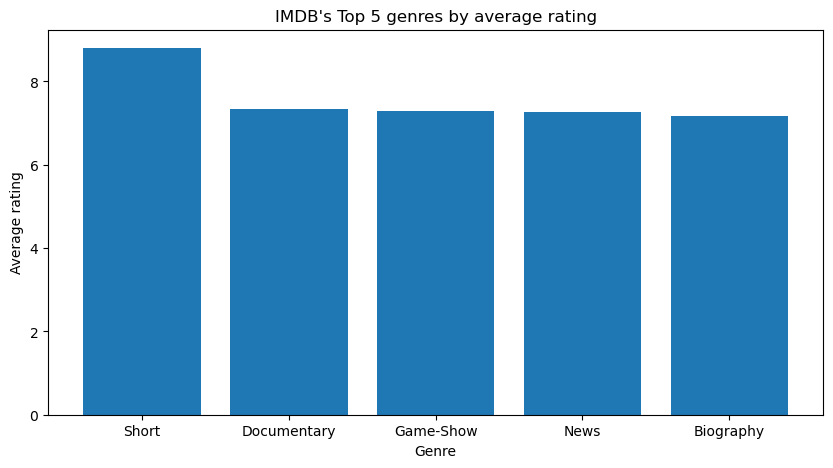

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(IMDB_Top_Genres.index, IMDB_Top_Genres.values)
ax.set_title("IMDB's Top 5 genres by average rating")
ax.set_xlabel('Genre')
ax.set_ylabel("Average rating")

plt.show()

The **Short** genre is the clear favourite with an average rating of nearly 9. The other genres follow with an almost similar rating of about 7 each. 

#### ii) Rotten Tomatoes Analysis

Since the Top 5 lists for Box Office and Rating are completely different (blockbusters vs. niche artistic films), I calculated a **Combined Rank** to find the genres that perform best across both categories (closest to the top in both lists).

In [60]:
# Merge the two Rotten Tomatoes dataframes on movie_id
RT_Merged = pd.merge(RT_Movie_Data, RT_Review_Data, on='id')

# Explode the genre column to have individual genres
RT_Exploded = RT_Merged.assign(genre=RT_Merged['genre'].str.split('|')).explode('genre')

# 1. Top 5 Box Office
# Note: We drop duplicates to count each movie's box office only once per genre
RT_Genre_Box_Office = RT_Exploded[['id', 'genre', 'box_office']].drop_duplicates() \
            .groupby('genre')['box_office'].mean().sort_values(ascending=False)
print("Top 5 Box Office:\n", RT_Genre_Box_Office.head(5))

# 2. Top 5 Rated
# We take the mean of all review ratings for the genre
RT_Genre_Rating = RT_Exploded.groupby('genre')['rating_y'].mean().sort_values(ascending=False)
print("Top 5 Rated:\n", RT_Genre_Rating[RT_Genre_Rating.index != ''].head(5))

# 3. Top 5 In Both (Combined Rank)
# Create a dataframe with both metrics
RT_Combined = pd.DataFrame({'box_office': RT_Genre_Box_Office, 'rating': RT_Genre_Rating})
# Rank each metric (1 is best)
RT_Combined['rank_bo'] = RT_Combined['box_office'].rank(ascending=False)
RT_Combined['rank_rating'] = RT_Combined['rating'].rank(ascending=False)
# Add ranks together (lower sum is better)
RT_Combined['total_rank'] = RT_Combined['rank_bo'] + RT_Combined['rank_rating']
# Sort by total rank
print("Top 5 in Both:\n", RT_Combined.sort_values('total_rank').head(5))

Top 5 Box Office:
 genre
Animation                      2.739254e+07
Kids and Family                2.117885e+07
Action and Adventure           1.704996e+07
Science Fiction and Fantasy    1.463068e+07
Romance                        1.290462e+07
Name: box_office, dtype: float64
Top 5 Rated:
 genre
Gay and Lesbian                3.378571
Cult Movies                    3.346296
Classics                       3.279208
Documentary                    3.243728
Art House and International    3.222062
Name: rating_y, dtype: float64
Top 5 in Both:
                       box_office    rating  rank_bo  rank_rating  total_rank
genre                                                                       
Animation           2.739254e+07  3.015096      1.0          9.0        10.0
Kids and Family     2.117885e+07  2.862248      2.0         13.0        15.0
Romance             1.290462e+07  2.973875      5.0         11.0        16.0
Documentary         2.209687e+06  3.243728     12.0          5.0      

The top 5 genres in terms of both box office revenue and rating are drama, comedy, romance, documentary and animation.

We can visualize the genres in the combined rank to see how they compare in terms of both ratings and box office revenue

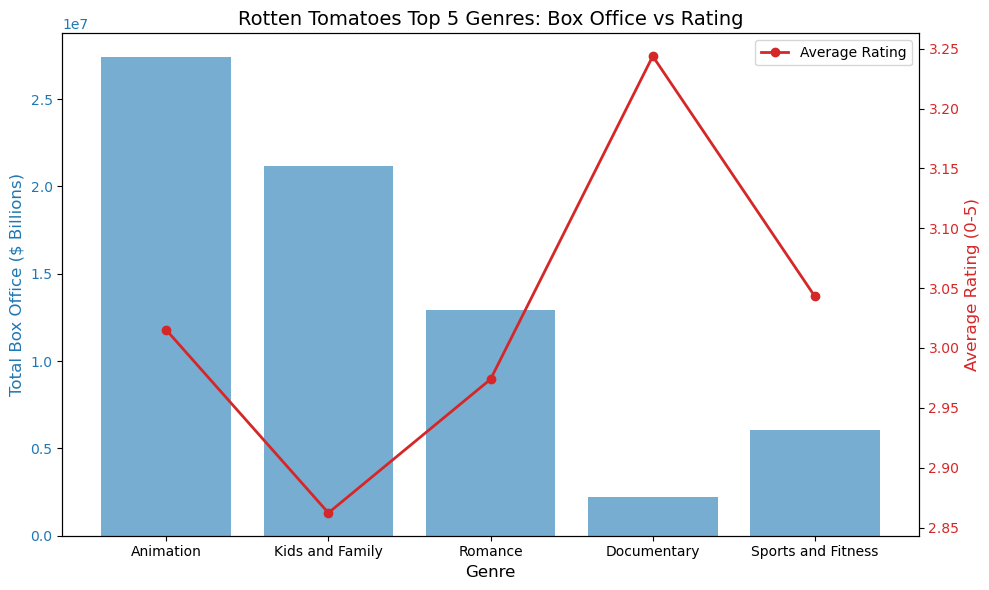

In [65]:
top_5 = RT_Combined.sort_values('total_rank').head()

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

# Axis 1: Box Office (Bar Chart)
color_bo = 'tab:blue'
ax1.bar(top_5.index, top_5['box_office'], color=color_bo, alpha=0.6, label="Box office earnings")
ax1.set_xlabel('Genre', fontsize=12)
ax1.set_ylabel('Total Box Office ($ Billions)', color=color_bo, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color_bo)

# Axis 2: Rating (Line Chart)
ax2 = ax1.twinx()
color_rate = 'tab:red'
ax2.plot(top_5.index, top_5['rating'], color=color_rate, marker='o', linewidth=2, label="Average Rating")
ax2.set_ylabel('Average Rating (0-5)', color=color_rate, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color_rate)

plt.title('Rotten Tomatoes Top 5 Genres: Box Office vs Rating', fontsize=14)
plt.tight_layout()
plt.legend(loc='best')
plt.show()

The documentary genre has very low box office revenue but is highly rated which makes it appear in the combined dataset.

The best genre in terms of box office return (around $3 billion per movie) and average rating is **animation**.

Let's take a look at the genres with the highest box office return.

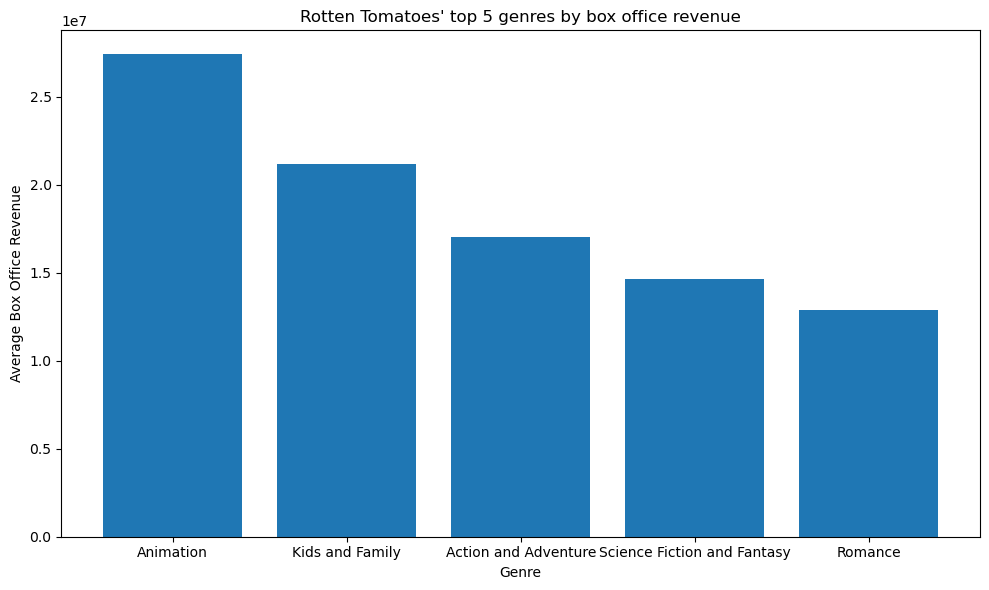

In [63]:
top_5 = RT_Genre_Box_Office.head()

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(top_5.index, top_5.values)
ax.set_title("Rotten Tomatoes' top 5 genres by box office revenue")
ax.set_ylabel("Average Box Office Revenue")
ax.set_xlabel('Genre')

plt.tight_layout()
plt.show()

**Animation** ranks highest in terms of average box office returns followed by kids and family, action and adventure, science fiction and fantasy, and finally romance

Let's look at the highest rated genres.

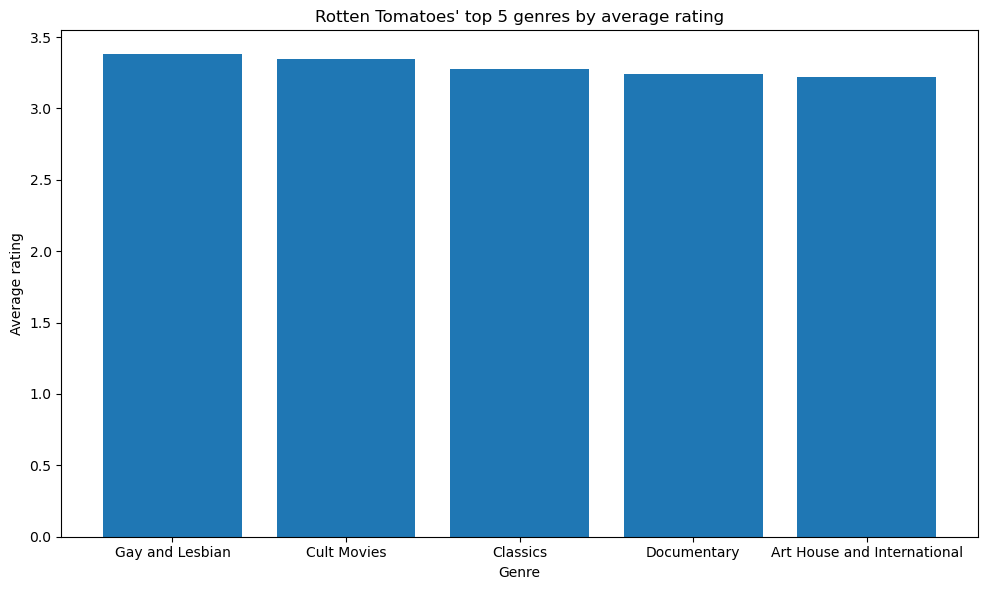

In [64]:
top_5 = RT_Genre_Rating[RT_Genre_Rating.index != ''].head()

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(top_5.index, top_5.values)
ax.set_title("Rotten Tomatoes' top 5 genres by average rating")
ax.set_xlabel('Genre')
ax.set_ylabel("Average rating")

plt.tight_layout()
plt.show()

The movies with the highest ratings tend to be niche artisitic films which might not have a high box office return.

#### iii) Combined

The genre that appears in both datasets (from IMDB and Rotten Tomatoes) is **Documentary**. Documentaries are the safest bet for a good genre of movie to make in terms of **critical acclaim (rating)**.

For a **good box office return**, the best genres are **Animation** and **Kids and Family**.